# Application of logistic regression to the classification problem

# Dataset description

The dataset contains information about the passengers of the Titanic, which sank on the night of April 15, 1912. A number of passengers were rescued due to many different factors, including their gender, age, which deck their cabin was on, social status, etc.

The dataset consists of various features that describe information about the passengers. Each row of the table is an individual passenger, with all the information about that passenger contained in its row.

Dataset description:
- **Survived** (target): whether passanger survived or not (0 = No, 1 = Yes);
- **Pclass**: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: gender (female или male)	
- **Age**: age in years
- **SibSp**: no. of siblings/spouses aboard the Titanic	
- **Parch**: no. of parents/children aboard the Titanic
- **Ticket**: ticket number	
- **Fare**: passenger fare
- **Cabin**: cabin number	
- **Embarked**: port of embarkation: (C = Cherbourg, Q = Queenstown, S = Southampton).

We need to solve the classification problem and learn to predict the target feature **Survived** (whether the passenger will survive) from the corresponding non-target features.


# Data preparation and exploratory analysis

In [91]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Import data

In [3]:
data = pd.read_csv('titanic_train.csv')
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN


In [10]:
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,981.000000,981.000000,782.000000,981.000000,981.000000,981.000000
mean,2.299694,0.382263,29.963448,0.480122,0.386340,32.517741
std,0.836593,0.486188,14.482025,0.989157,0.873987,49.306258
min,1.000000,0.000000,0.333300,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     981 non-null    int64  
 1   survived   981 non-null    int64  
 2   name       981 non-null    object 
 3   sex        981 non-null    object 
 4   age        782 non-null    float64
 5   sibsp      981 non-null    int64  
 6   parch      981 non-null    int64  
 7   ticket     981 non-null    object 
 8   fare       981 non-null    float64
 9   cabin      212 non-null    object 
 10  embarked   981 non-null    object 
 11  home.dest  567 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 92.1+ KB


Find the number of missing values in the <code>age</code> column:

In [7]:
data['age'].isnull().sum()

199

Calculate the proportion of survivors.

In [9]:
round(data.survived.value_counts(normalize = True), 3)

survived
0    0.618
1    0.382
Name: proportion, dtype: float64

Determine the proportion of missing values within each feature and get rid of those features where the proportion of missing values is greater than a third. Also delete the column <code>ticket</code> as this information is unlikely to be useful.

In [43]:
deleted_features = (data.isnull().sum() > data.count()/3).reset_index()
deleted_features = deleted_features['index'].loc[deleted_features[0] == True].to_list()
deleted_features

['cabin', 'home.dest']

In [44]:
data.drop(columns=deleted_features, inplace=True)
data.drop(columns='ticket', inplace=True)

From the dataset description, you can see that the columns <code>sibsp</code> and <code>parch</code> are essentially responsible for family size. Replace these two columns with the <code>fam_size</code> column, whose values will be calculated as the sum of the corresponding values in the columns <code>sibsp</code> and <code>parch</code>.

In [47]:
data['fam_size'] = data.sibsp + data.parch
data.drop(columns=['sibsp', 'parch'], inplace=True)

In [49]:
round(data.fam_size.mean(), 3)

0.866

The resulting dataset will be called **INITIAL** (the features discarded at this stage do not need to be returned at any of the subsequent stages of the task).

In [54]:
INITIAL = data.copy()
INITIAL.shape[1] - 1

7

Based on available statistics, estimate the probability of survival if the passenger is a member of the particular category (this category is pecified in your individual assignment).
male and pclass = 3

In [69]:
print('Probability of survival if the passenger is a member of the particular category =', round(INITIAL.loc[(INITIAL['sex'] == 'male') & (INITIAL['pclass'] == 3) & (INITIAL['survived'] == 1)].shape[0] / INITIAL.loc[(INITIAL['sex'] == 'male') & (INITIAL['pclass'] == 3)].shape[0], 3))

Probability of survival if the passenger is a member of the particular category = 0.164


Construct histograms of survivors and non-survivors by age.

Text(0.5, 1.0, 'Distribution non-survived')

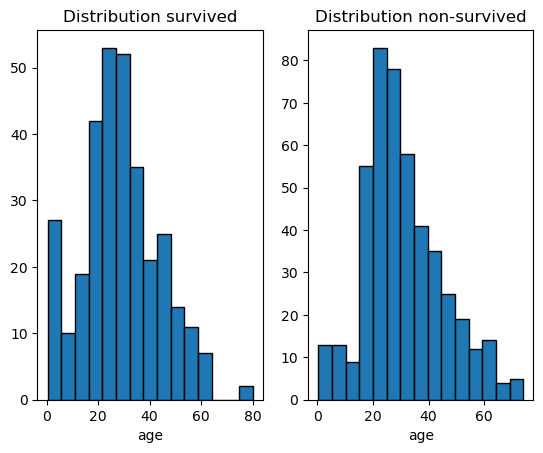

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(INITIAL['age'].loc[INITIAL['survived'] == 1], edgecolor = 'black', bins = 15)
ax1.set_xlabel('age')
ax1.set_title('Distribution survived')

ax2.hist(INITIAL['age'].loc[INITIAL['survived'] == 0], edgecolor = 'black', bins = 15)
ax2.set_xlabel('age')
ax2.set_title('Distribution non-survived')

# Model based on numerical features

## Removing rows with missing values

As a base model, it makes sense to build a model with minimal effort.

From the initial dataset, remove all categorical features as well as rows containing missing values.

Use <code>train_test_split()</code> to split the dataset into training and test samples <b>with the parameters specified in your individual assigment</b>. Use stratification by column <code>survived</code>.

Train <code>LogisticRegression()</code> model (<b>with the parameters specified in your individual assigment</b>) on training dataset, and evaluate the model on test dataset.

Compute <code>f1_score()</code> of the model on the test dataset (we recommend using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">the corresponding function</a> with default parameters).

In [101]:
X = INITIAL.select_dtypes(exclude='object')
X.dropna(inplace=True)
y = X['survived']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='survived'), y, test_size=0.2, random_state=23, stratify=X['survived'])

In [103]:
base_model = LogisticRegression(random_state=23, max_iter=1000)
base_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=23)

In [107]:
print(classification_report(y_test, base_model.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.669     0.871     0.757        93
           1      0.667     0.375     0.480        64

    accuracy                          0.669       157
   macro avg      0.668     0.623     0.619       157
weighted avg      0.668     0.669     0.644       157



## Filling missing values with the mean

The quality of the resulting model leaves much to be desired. It makes sense to try to fill the missing values. Remove categorical features from the initial dataset, and fill missing values with the mean value of the column. The following steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [124]:
def model(data, drop_na = False):
    X = data.select_dtypes(exclude='object')
    if drop_na == True:
        X.dropna(inplace=True)
    y = X['survived']

    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='survived'), y, test_size=0.2, random_state=23, stratify=X['survived'])

    base_model = LogisticRegression(random_state=23, max_iter=1000)
    base_model.fit(X_train, y_train)

    f1 = f1_score(y_test, base_model.predict(X_test))
    return round(f1, 3)

In [125]:
model(INITIAL.fillna(INITIAL.select_dtypes(exclude='object').mean()))

0.488

## Filling missing values based on honorifics

Obviously, filling missing values in the <code>age</code> column with mean is not the smartest idea. Perhaps you should perform this procedure somehow more intelligently, for example, with an eye on appealing to the person. 

You can notice that the initial dataset in the column contains information about the social status of the passenger, namely, there are appeals <code>Mr., Mrs., Dr.</code>, etc. Based on this information, we can try to make an assumption about the passenger's age.

Put the column <code>name</code> back into consideration. Create a separate <code>honorific</code> column and put the appeal values there.

Calculate the number of unique appeals.

In [134]:
INITIAL_honorific = INITIAL.copy()
INITIAL_honorific['honorific'] = INITIAL['name'].str.extract('([A-Za-z]+)\.')
pd.crosstab(INITIAL_honorific['sex'], INITIAL_honorific['honorific'])

honorific,Capt,Col,Countess,Don,Dona,Dr,Major,Master,Miss,Mlle,Mr,Mrs,Ms,Rev
sex,,,,,,,,,,,,,,
female,0,0,1,0,1,0,0,0,194,2,0,145,2,0
male,1,3,0,1,0,6,1,46,0,0,572,0,0,6


In [147]:
print(f'Number of unique appeals - {INITIAL_honorific["honorific"].nunique()},\n{list(INITIAL_honorific["honorific"].unique())}')

Number of unique appeals - 14,
['Miss', 'Mrs', 'Mr', 'Master', 'Mlle', 'Rev', 'Ms', 'Col', 'Dona', 'Dr', 'Countess', 'Major', 'Don', 'Capt']


Most likely, it makes sense to reduce the number of appeals, adding small groups to the more numerous ones, as there seems to be no fundamental difference between, for example, <code>Don</code> and <code>Mr</code>. Note that <code>Master</code> is a former appeal to a child, we will work with this appeal separately.




Make the following substitutions:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [148]:
INITIAL_honorific['honorific'].replace(['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], 'Mr', inplace=True)
INITIAL_honorific['honorific'].replace(['Dona', 'Countess'], 'Mrs', inplace=True)
INITIAL_honorific['honorific'].replace(['Mlle', 'Ms'], 'Miss', inplace=True)

In [149]:
pd.crosstab(INITIAL_honorific['sex'], INITIAL_honorific['honorific'])

honorific,Master,Miss,Mr,Mrs
sex,,,,
female,0,198,0,147
male,46,0,590,0


Calculate the proportion of rows with the <code>Master</code> value relative to the number of all males.

In [160]:
round(INITIAL_honorific[INITIAL_honorific['honorific'] == 'Master'].shape[0] / INITIAL_honorific[INITIAL_honorific['sex'] == 'male'].shape[0], 3)

0.072

Calculate the average age of the category specified in your individual assigment.

In [154]:
round(INITIAL_honorific['age'].loc[INITIAL_honorific['honorific'] == 'Mr'].mean(), 3)

32.9

Fill the missing values in the column <code>age</code> with the mean corresponding to the mean of the <code>honorific</code> category.

Get rid of non-numeric features. Next steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [168]:
INITIAL_honorific.groupby('honorific')['age'].mean()

honorific
Master     5.128205
Miss      22.005765
Mr        32.900438
Mrs       36.984252
Name: age, dtype: float64

In [169]:
INITIAL_honorific.loc[(INITIAL_honorific['age'].isnull()) & (INITIAL_honorific['honorific'] == 'Master'), 'age'] = INITIAL_honorific.groupby('honorific')['age'].mean()['Master']
INITIAL_honorific.loc[(INITIAL_honorific['age'].isnull()) & (INITIAL_honorific['honorific'] == 'Miss'), 'age'] = INITIAL_honorific.groupby('honorific')['age'].mean()['Miss']
INITIAL_honorific.loc[(INITIAL_honorific['age'].isnull()) & (INITIAL_honorific['honorific'] == 'Mr'), 'age'] = INITIAL_honorific.groupby('honorific')['age'].mean()['Mr']
INITIAL_honorific.loc[(INITIAL_honorific['age'].isnull()) & (INITIAL_honorific['honorific'] == 'Mrs'), 'age'] = INITIAL_honorific.groupby('honorific')['age'].mean()['Mrs']

In [170]:
model(INITIAL_honorific)

0.484

# Model that uses categorical features

In the original dataset, fill the missing values in the column <code>age</code> with values based on the appeals (as in the previous step). 

After that, drop the features <code>name</code> and <code>honorific</code>. They have fulfilled their function.

Perform <code>one-hot</code> encoding of the non-numeric features, for example, with <code>pd.get_dummies(drop_first=True)</code>. Then follow the familiar pattern: split, train, evaluate.

Compute <code>f1_score()</code> of the model on the test dataset.

In [174]:
INITIAL_categorical = INITIAL_honorific.copy()
INITIAL_categorical.drop(columns=['name', 'honorific'], inplace=True)
INITIAL_categorical = pd.get_dummies(INITIAL_categorical, drop_first=True)

model(INITIAL_categorical)

0.681